In [6]:
pip install  langchain_openai langchain_core langgraph langgraph-prebuilt langgraph-checkpoint-sqlite langchain-chroma langchain-community


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os, getpass
def set_env(var:str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
set_env("OPENAI_API_KEY")

In [8]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage 

llm = ChatOpenAI(model="gpt-4o-mini")

def assistant(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

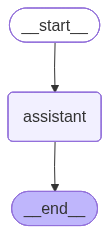

In [9]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

workflow = StateGraph(MessagesState)

workflow.add_node("assistant", assistant)

workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", END)

graph = workflow.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [
    HumanMessage("Hi I am Kripesh")
]

messages = graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi I am Kripesh
================================== Ai Message ==================================

Hi Kripesh! How can I assist you today?


### ADD MEMORY

In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_memory = workflow.compile(checkpointer=memory)

In [12]:
config = {"configurable":{"thread_id": "1"}}

messages = [
    HumanMessage(content="Hi I am Kripesh Das")
]

messages = graph_memory.invoke({"messages": messages}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi I am Kripesh Das
================================== Ai Message ==================================

Hello, Kripesh Das! How can I assist you today?


In [13]:
messages = [
    HumanMessage(content="Hi Do you even remember my name?")
]

messages = graph_memory.invoke({"messages": messages}, config)

for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

Hi I am Kripesh Das
================================== Ai Message ==================================

Hello, Kripesh Das! How can I assist you today?
================================ Human Message =================================

Hi Do you even remember my name?
================================== Ai Message ==================================

Yes, you mentioned that your name is Kripesh Das. How can I help you today?


### OPTIMIZED SHORT-TERM MEMORY ---> SUMMARIZATION

In [14]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str


In [15]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    
    summary = state.get("summary","")
    
    if summary:
        
        system_message = f"Summary of the conversation: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
        
    else:
        
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

In [16]:
def summarize_conversation(state: State):
    
    summary = state.get("summary","")
    
    if summary:
        
        summary_message = (
            f"This summary is the conversation to the date: {summary}\n \n"
            "Extend the summary by taking the information of the new message above:"
        )
        
    else:
        
        summary_message = "Create a summary of the conversation"
        
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all except for the recent two messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [17]:
from typing_extensions import Literal

def should_continue(state: State) -> Literal ["summarize_conversation", END]:
    # Either END or summarise the conversation
    messages = state["messages"]
    
    if len(messages) > 20:
        return "summarize_conversation"
    
    return END

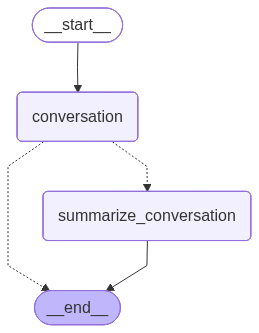

In [18]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation",should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### PERSISTANCE

In [19]:
import sqlite3

db_path = "example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [20]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

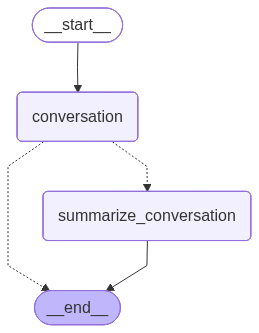

In [21]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation",should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Hi I am Kripesh Das")]

messages = graph.invoke({"messages": messages}, config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi I am Kripesh Das
================================== Ai Message ==================================

Hello Kripesh Das! How can I assist you today?
